In [24]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings("ignore")
# 空值填充
order = pd.read_csv('./ORDER.csv').fillna(0)

def month_int(ret,dt):
    # 用于月份处理，将日期变成数字，并且新加一列month_int用于记录该日期是从15年01月开始算的第几个月
    def month_int_gen(a):
        return int(a[dt].split('-')[1])-1+(int(a[dt].split('-')[2])-15)*12
    ret[dt].replace(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],['1','2','3','4','5','6','7','8','9','10','11','12'],regex=True,inplace=True)
    ret['MONTH_INT'] = ret.apply(month_int_gen,axis=1)

month_int(order,'MONTH')
# 去除重复值
order = order.drop_duplicates(subset=['PART_NO','MONTH_INT'],keep='last')
order=order.sort_values(by='MONTH_INT')
part_no_list = list(order['PART_NO'].unique())

In [25]:
# 零部件属性信息分析,特征处理
class LocalOneHotEncoder(object):
  def __init__(self, target_columns):
    '''
    @param: target_columns --- To perform one-hot encoding column name list. 
    '''
    self.enc = OneHotEncoder(handle_unknown='ignore')
    self.col_names = target_columns

  def fit(self, df):
    '''
    @param: df --- pandas DataFrame
    '''
    self.enc.fit(df[self.col_names].values)
    self.labels = np.array(self.enc.categories_).ravel()
    self.new_col_names = self.gen_col_names(df)

  def gen_col_names(self, df):
    '''
    @param:  df --- pandas DataFrame
    '''
    new_col_names = []
    for col in self.col_names:
      for val in df[col].unique():
        new_col_names.append("{}_{}".format(col, val))
    return new_col_names

  def transform(self, df):
     '''
     @param:  df --- pandas DataFrame
     '''
     return pd.DataFrame(data = self.enc.transform(df[self.col_names]).toarray(), 
                         columns = self.new_col_names, 
                         dtype=int) 


def getPartInfo():
    part_list = pd.read_csv('./LIST.csv')
#     print('PART_NO个数:' + str(len(part_list['PART_NO'].unique())))
#     print('KPDS个数:' + str(len(part_list['KPDS'].unique())))
#     print('CAR_CLASS个数:' + str(len(part_list['CAR_CLASS'].unique())))
#     print('PIDT个数:' + str(len(part_list['PIDT'].unique())))
#     print('REPAIR_TYPE个数:' + str(len(part_list['REPAIR_TYPE'].unique())))
#     print('TYPE_CODE个数:' + str(len(part_list['TYPE_CODE'].unique())))
#     print('CONSTRUCT_NAME个数:' + str(len(part_list['CONSTRUCT_NAME'].unique())))

    ## 数据预处理
    month_int(part_list,"PIDT")

    ONEHOT_COLUMNS = ['CAR_CLASS','REPAIR_TYPE','TYPE_CODE','CONSTRUCT_NAME']
    local_ohe = LocalOneHotEncoder(ONEHOT_COLUMNS)
    local_ohe.fit(part_list)
    oht_df = local_ohe.transform(part_list)
#     print(oht_df)

    part_list_date = part_list.iloc[:,-1]
    part_list_id = part_list.iloc[:,0]
    part_list_new = pd.concat([part_list_id,oht_df,part_list_date], axis=1)
    part_list_new.drop_duplicates(['PART_NO'],keep='last',inplace=True)
    return part_list_new

part_list_new = getPartInfo()

# xgb序列特征构架
d_part_train_x={}
d_part_train_y1={}
d_part_train_y2={}
d_part_train_x_lst={}

for j in range(len(part_no_list)):
# for j in range(1):
    if(j%100==0):
        print(j)
    order_part = order[order['PART_NO']==part_no_list[j]]
    for i in range(23,81,10):
        if i==23:
            train_x = order_part[(order_part['MONTH_INT'] <= i )&( order_part['MONTH_INT'] >= i-23)][['DM01','REPAIR_CNT','REPAIR_AMOUNT','RUN_DIST','MONTH_INT']]
            train_x = train_x.to_numpy().T.reshape(1,-1)
            train_y1 = order_part[(order_part['MONTH_INT'] == i+1 )]['DM01']
            train_y2 = np.array([order_part[(order_part['MONTH_INT'] == i+1 )|(order_part['MONTH_INT'] == i+2 )|(order_part['MONTH_INT'] == i+3 )]['DM01'].sum()])

        else:
            train_x_tmp = order_part[(order_part['MONTH_INT'] <= i )&( order_part['MONTH_INT'] >= i-23)][['DM01','REPAIR_CNT','REPAIR_AMOUNT','RUN_DIST','MONTH_INT']]
            train_x_tmp = train_x_tmp.to_numpy().T.reshape(1,-1)
            train_y1_tmp = order_part[(order_part['MONTH_INT'] == i+1 )]['DM01']
            train_y2_tmp = np.array([order_part[((order_part['MONTH_INT'] == i+1 )|(order_part['MONTH_INT'] == i+2 )|(order_part['MONTH_INT'] == i+3 ))]['DM01'].sum()])

            train_x = np.append(train_x,train_x_tmp,axis=0)
            train_y1=np.append(train_y1,train_y1_tmp,axis=0)
            train_y2=np.append(train_y2,train_y2_tmp,axis=0)
        

    d_part_train_x[part_no_list[j]]=train_x
    d_part_train_y1[part_no_list[j]]=train_y1
    d_part_train_y2[part_no_list[j]]=train_y2
    
    #    最后一个输出数据
    i=83
    train_x_lst = order_part[(order_part['MONTH_INT'] <= i )&( order_part['MONTH_INT'] >= i-23)][['DM01','REPAIR_CNT','REPAIR_AMOUNT','RUN_DIST','MONTH_INT']]
    train_x_lst = train_x_lst.to_numpy().T.reshape(1,-1)
    d_part_train_x_lst[part_no_list[j]]=train_x_lst

    
# 零件特征和序列特征拼接
d_part_train_x_all={}
d_part_train_x_all_lst={}
for part in part_no_list:
    feat_part = part_list_new[part_list_new['PART_NO']==part][['CAR_CLASS_A0-SEDAN', 'CAR_CLASS_B-MPV', 'CAR_CLASS_B-SEDAN',
       'CAR_CLASS_A-SEDAN', 'CAR_CLASS_A0-SUV', 'CAR_CLASS_B-SUV',
       'REPAIR_TYPE_维修', 'REPAIR_TYPE_通竞', 'REPAIR_TYPE_保养', 'REPAIR_TYPE_其它',
       'TYPE_CODE_机能件', 'TYPE_CODE_钣金件', 'TYPE_CODE_易损件', 'TYPE_CODE_空调滤',
       'TYPE_CODE_火花塞', 'TYPE_CODE_滤清器', 'TYPE_CODE_燃滤', 'TYPE_CODE_空滤',
       'TYPE_CODE_召回件', 'TYPE_CODE_电瓶', 'TYPE_CODE_刹车片', 'TYPE_CODE_雨刮片',
       'CONSTRUCT_NAME_易损件', 'CONSTRUCT_NAME_底盘', 'CONSTRUCT_NAME_车体',
       'CONSTRUCT_NAME_电器', 'CONSTRUCT_NAME_变速箱', 'CONSTRUCT_NAME_保养',
       'CONSTRUCT_NAME_发动机', 'CONSTRUCT_NAME_其他', 'CONSTRUCT_NAME_内饰',
       'CONSTRUCT_NAME_标准件', 'MONTH_INT']].to_numpy()
    feat_part_lst = np.repeat(feat_part,1,axis=0)
    feat_all_lst = np.concatenate((d_part_train_x_lst[part],feat_part_lst),axis=1)
    d_part_train_x_all_lst[part]=feat_all_lst
    
    feat_part = np.repeat(feat_part,d_part_train_x[part].shape[0],axis=0)
    feat_all = np.concatenate((d_part_train_x[part],feat_part),axis=1)
    d_part_train_x_all[part]=feat_all

for part in part_no_list:
    if part==part_no_list[0]:
        x=d_part_train_x_all[part]
        y1=d_part_train_y1[part]
        y2=d_part_train_y2[part]
        x_lst=d_part_train_x_all_lst[part]
    else:
        x=np.concatenate((x,d_part_train_x_all[part]))
        y1=np.concatenate((y1,d_part_train_y1[part]))
        y2=np.concatenate((y2,d_part_train_y2[part]))
        x_lst=np.concatenate((x_lst,d_part_train_x_all_lst[part]))

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200


In [26]:
# 模型
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

X=x
y1=y1
y2=y2

x_train, x_test, y_train1, y_test1 = train_test_split(X, y1, test_size=0.2, random_state=0)
y_test1[np.where(y_test1==0)]=10

x_train, x_test, y_train2, y_test2 = train_test_split(X, y2, test_size=0.2, random_state=0)
y_test2[np.where(y_test2==0)]=10


# xgboost
from xgboost import XGBRegressor as XGBR
# reg1用来训练未来一个月的值
reg1 = XGBR(n_estimators=100).fit(x_train,y_train1) 
y_pred1 = reg1.predict(x_test)
y_pred1[np.where(y_pred1<0)]=0
mape_score = mean_absolute_percentage_error(y_test1, y_pred1)
print("mape_score1:" + str(mape_score))
ret1=reg1.predict(x_lst)

# reg2用来训练未来三个月的值
reg2 = XGBR(n_estimators=200).fit(x_train,y_train2) 
y_pred2 = reg2.predict(x_test)
y_pred2[np.where(y_pred2<0)]=0
mape_score = mean_absolute_percentage_error(y_test2, y_pred2)
print("mape_score2:" + str(mape_score))
ret2=reg2.predict(x_lst)

f=open('ret_xgb.txt','w')
for i in range(len(part_no_list)):
    f.write(str(part_no_list[i])+'  :  '+str(round(ret1[i]))+'   '+str(round(ret2[i]))+'\n')

mape_score1:0.5215941025879247
mape_score2:0.43424408414569615


In [27]:
# 模型2 arima
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot as plt 
from sklearn.metrics import mean_absolute_percentage_error
from tqdm import tqdm

warnings.filterwarnings("ignore")
mapes=[]
ahead=3 # 向前预测多少个值
f=open('ret_arima.txt','w')

for i in tqdm(range(len(part_no_list))):
#     print(i)
    seq1=order[order["PART_NO"]==part_no_list[i]][['DM01']].reset_index(drop=True)
    model = ARIMA(seq1, order=(1,1,1))
    res=model.fit()

    data=seq1['DM01']
    pred_value=res.predict(0, len(data)+ahead) # 预测的第一个数据是0
    f.write(str(part_no_list[i])+' : '+str(round(pred_value[len(data)+1]))+'  '+str(round(pred_value[len(data)+1]+pred_value[len(data)+2]+pred_value[len(data)+3]))+'\n')
    seq1.to_numpy()[np.where(seq1==0)]=10
    mape_score = mean_absolute_percentage_error(seq1, res.fittedvalues.to_numpy())
    mapes.append(mape_score)
#     print(part_no_list[i]+' mape: '+str(mape_score))
print('total mape average = ',str(np.mean(mapes)))
f.close()

100%|██████████████████████████████████████████████████████████████████████████████| 2289/2289 [01:27<00:00, 26.23it/s]

total mape average =  0.582688503089104


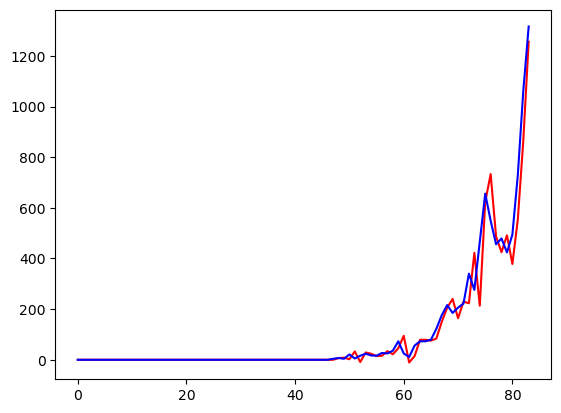

In [29]:
# 画图 红色为预测值，蓝色为实际值
seq1=order[order["PART_NO"]=='835994ECL9'][['DM01']].reset_index(drop=True)
model = ARIMA(seq1, order=(2,1,2))
res=model.fit()
plt.plot(res.fittedvalues, color='red')
plt.plot(seq1, color='blue')